In [733]:
import random
import time
import numpy as np
np.random.seed(0)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split , KFold , GridSearchCV
from sklearn.preprocessing import MinMaxScaler , OneHotEncoder ,LabelEncoder 
from sklearn.feature_selection import SelectKBest  ,f_classif 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import  VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pickle
# Load the dataset
df = pd.read_csv('SongPopularity_Milestone2.csv')

# Display the first few rows of the dataset
df.head()

,Song,Album,Album Release Date,Artist Names,Artist(s) Genres,Hot100 Ranking Year,Hot100 Rank,Song Length(ms),Spotify Link,Song Image,...,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Valence,Key,Mode,Time Signature
0,I Need You,I Need You,1/30/2001,['LeAnn Rimes'],"['country dawn', 'contemporary country', 'coun...",2000,44,229826,https://open.spotify.com/track/046MBhhgQJJghnb...,https://i.scdn.co/image/ab67616d00001e025cf523...,...,0.736,0.000096,0.118,-7.124,0.0367,144.705,0.564,7,1,4
1,Sweet Lady,Tyrese,8/31/1998,['Tyrese'],"['hip pop', 'contemporary r&b', 'urban contemp...",1999,43,290600,https://open.spotify.com/track/1Dx8rIZaXzZPvUQ...,https://i.scdn.co/image/ab67616d00001e0283422e...,...,0.522,0.000000,0.240,-6.254,0.0383,66.024,0.584,9,0,4
2,You Take My Breath Away - Mono Version,Sooner or Later,1979,['Rex Smith'],['bubblegum pop'],1979,86,197453,https://open.spotify.com/track/3BCMsz55asr7Yr6...,https://i.scdn.co/image/ab67616d00001e02d1741c...,...,0.600,0.000026,0.523,-7.913,0.0357,141.912,0.272,11,1,4
3,If I Give My Heart to You (with The Mellomen),Golden Girl (The Columbia Recordings 1944-1966),1945,"['Doris Day', 'The Mellomen']","['adult standards', 'easy listening', 'movie t...",1954,20,169066,https://open.spotify.com/track/20G1XJaTwIm2Iuw...,https://i.scdn.co/image/ab67616d00001e02f2ee02...,...,0.059,0.000000,0.103,-16.131,0.0497,76.642,0.331,9,1,4
4,Don't Forget About Us (As Made Famous By Maria...,Drew's Famous # 1 Karaoke Hits: Sing the Hits ...,8/16/2011,['The Karaoke Crew'],['karaoke'],2006,50,251013,https://open.spotify.com/track/28BSc2ZmO0Oe3iv...,https://i.scdn.co/image/ab67616d00001e02b0d3e3...,...,0.348,0.001280,0.247,-10.669,0.0545,143.595,0.385,7,0,4


In [734]:
# Remove duplicated
df = df[~df.duplicated()==1]


#Remove the Square Brackets from the artists

df["Artist Names"]=df["Artist Names"].str.replace("[", "")
df["Artist Names"]=df["Artist Names"].str.replace("]", "")
df["Artist Names"]=df["Artist Names"].str.replace("'", "")


df["Artist(s) Genres"]=df["Artist(s) Genres"].str.replace("[", "")
df["Artist(s) Genres"]=df["Artist(s) Genres"].str.replace("]", "")
df["Artist(s) Genres"]=df["Artist(s) Genres"].str.replace("'", "")

# Transform milliseconds to minutes
df["Song Length(mn)"] = df["Song Length(ms)"]/60000
df.drop(columns="Song Length(ms)", inplace=True)


Total number of features: 24
Number of categorical features: 4
Number of continuous features: 20


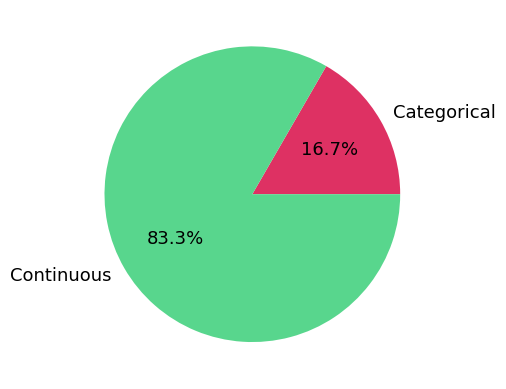

['PopularityLevel', 'Key', 'Mode', 'Time Signature']

In [735]:
cat_features = [col for col in df.columns if df[col].nunique() < 50]
cont_features = [col for col in df.columns if df[col].nunique() >= 50]

print(f'Total number of features: {len(cat_features) + len(cont_features)}')
print(f'\033[92mNumber of categorical features: {len(cat_features)}')
print(f'\033[96mNumber of continuous features: {len(cont_features)}')

plt.pie([len(cat_features), len(cont_features)], 
        labels=['Categorical', 'Continuous'],
        colors=['#DE3163', '#58D68D'],
        textprops={'fontsize': 13},
        autopct='%1.1f%%')
plt.show()
cat_features

In [736]:
numeric_columns = df.columns[df.dtypes != 'object']
obj_columns= df.columns[df.dtypes == 'object']
obj_columns

Index(['Song', 'Album', 'Album Release Date', 'Artist Names',
       'Artist(s) Genres', 'Spotify Link', 'Song Image', 'Spotify URI',
       'PopularityLevel'],
      dtype='object')

In [737]:
data = df.copy()
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = pd.Categorical(data[col]).codes

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Sort the correlation of features with the target variable
correlation_with_target = correlation_matrix['PopularityLevel'].sort_values(ascending=False)

# Select features with correlation above a threshold (e.g., 0.3)
selected_features = correlation_with_target[correlation_with_target.abs() > 0.05].index

# Filter the DataFrame to keep only selected features
df_selected_features = data[selected_features]
df_selected_features

,PopularityLevel,Hot100 Ranking Year,Loudness,Energy,Artist(s) Genres,Speechiness,Danceability,Album Release Date,Valence,Hot100 Rank,Acousticness
0,0,2000,-7.124,0.736,366,0.0367,0.478,157,0.564,44,0.0200
1,0,1999,-6.254,0.522,978,0.0383,0.588,2177,0.584,43,0.2330
2,0,1979,-7.913,0.600,184,0.0357,0.313,868,0.272,86,0.4760
3,0,1954,-16.131,0.059,15,0.0497,0.503,814,0.331,20,0.9730
4,1,2006,-10.669,0.348,1114,0.0545,0.843,2073,0.385,50,0.0149
...,...,...,...,...,...,...,...,...,...,...,...
6186,0,1991,-7.694,0.862,1089,0.0620,0.875,1450,0.915,88,0.0116
6187,2,2006,-4.680,0.799,845,0.0993,0.787,53,0.835,8,0.1890
6188,0,2006,-3.309,0.819,1758,0.2380,0.684,551,0.250,43,0.2620
6189,2,2008,-3.142,0.786,1279,0.0301,0.583,1980,0.573,7,0.0208


In [738]:
df = df[selected_features]

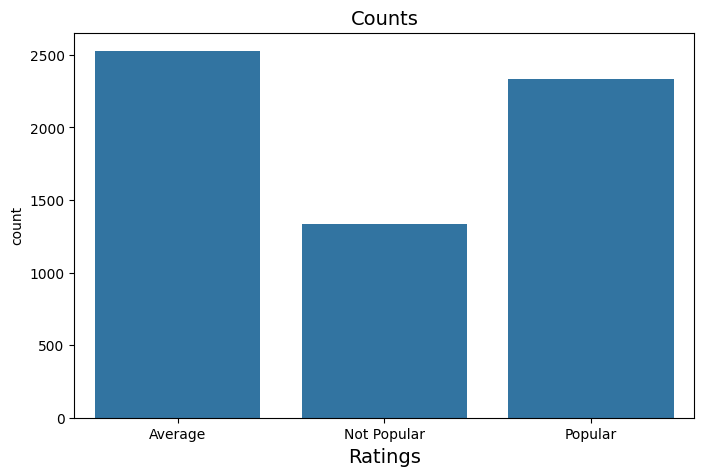

In [739]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
_ = sns.countplot(x='PopularityLevel', data=df)
_ = plt.xlabel('Ratings', fontsize=14)
_ = plt.title('Counts', fontsize=14)

In [740]:
df['PopularityLevel']=pd.Categorical(df['PopularityLevel']).codes
df['PopularityLevel']

0       0
1       0
2       0
3       0
4       1
       ..
6186    0
6187    2
6188    0
6189    2
6190    0
Name: PopularityLevel, Length: 6191, dtype: int8

In [741]:
X= df.drop(['PopularityLevel'], axis=1)
y= df['PopularityLevel']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=109) # 80% training and 20% test
print(f"No. of xtraining examples: {X_train.shape}")
print(f"No. of ytesting examples: {y_test.shape}")
print(f"No. of ytraning examples: {y_train.shape}")
print(f"No. of xtesting examples: {X_test.shape}")

No. of xtraining examples: (4952, 10)
No. of ytesting examples: (1239,)
No. of ytraning examples: (4952,)
No. of xtesting examples: (1239, 10)


In [742]:
X_train= X_train.reset_index(drop=True)
X_test= X_test.reset_index(drop=True)
y_train= y_train.reset_index(drop=True)
y_test= y_test.reset_index(drop=True)

In [743]:
obj_columns = ['Album Release Date']
encode = LabelEncoder()
for col in obj_columns:
    # Encode the data and store it in a variable
    X_train_encoded = encode.fit_transform(X_train[col])
    
    #Replace Columns (original data discarded)
    X_train[col] = X_train_encoded  
    with open('encode.pkl', 'wb') as f:
         pickle.dump(encode, f)

# Now X_train contains the encoded data
X_train.head()

,Hot100 Ranking Year,Loudness,Energy,Artist(s) Genres,Speechiness,Danceability,Album Release Date,Valence,Hot100 Rank,Acousticness
0,1967,-5.862,0.717,"folk rock, singer-songwriter, rock-and-roll, p...",0.0435,0.672,50,0.758,54,0.256
1,1986,-7.753,0.807,"soft rock, rock drums",0.0548,0.620,125,0.579,88,0.471
2,2000,-6.269,0.447,karaoke,0.0276,0.547,58,0.490,95,0.673
3,1994,-11.451,0.250,"contemporary r&b, boy band, r&b",0.0300,0.322,42,0.352,28,0.892
4,1981,-9.963,0.862,"country dawn, classic country pop, soft rock",0.0535,0.658,29,0.969,14,0.211


In [744]:
# Transform features by scaling specific features to a given range
ctr = ColumnTransformer([('minmax', MinMaxScaler(), ['Hot100 Ranking Year', 'Hot100 Rank']),
                         ('categorical', OneHotEncoder(sparse_output=False), ["Artist(s) Genres"])],
                        remainder='drop')           

ctr.fit(X_train)

# Transform the selected columns
X_train_preprocessed = ctr.transform(X_train)

# Retrieve the column names after transformation
transformed_feature_names = ctr.get_feature_names_out(input_features=X_train.columns)

# Convert the transformed array to a DataFrame
X_train_transformed = pd.DataFrame(X_train_preprocessed, columns=transformed_feature_names)

m=['Hot100 Ranking Year', 'Hot100 Rank',  "Artist(s) Genres" ]
# Drop the original categorical columns from X_train
X_train.drop(m, axis=1, inplace=True)

# Concatenate the encoded features with the original data
X_train = pd.concat([X_train, X_train_transformed], axis=1)
# Save the preprocessing transformer
with open('preprocessing.pkl', 'wb') as f:
     pickle.dump(ctr, f)
X_train

,Loudness,Energy,Speechiness,Danceability,Album Release Date,Valence,Acousticness,minmax__Hot100 Ranking Year,minmax__Hot100 Rank,categorical__Artist(s) Genres_,...,"categorical__Artist(s) Genres_vocal jazz, jazz blues, soul","categorical__Artist(s) Genres_vocal jazz, jazz, torch song","categorical__Artist(s) Genres_vocal jazz, lounge, adult standards",categorical__Artist(s) Genres_west coast rap,"categorical__Artist(s) Genres_west coast rap, chicano rap","categorical__Artist(s) Genres_western swing, bluegrass gospel, country boogie, yodeling, country gospel",categorical__Artist(s) Genres_yacht rock,"categorical__Artist(s) Genres_yacht rock, quiet storm, soft rock, mellow gold","categorical__Artist(s) Genres_yacht rock, soft rock, mellow gold, singer-songwriter, classic rock",categorical__Artist(s) Genres_yodeling
0,-5.862,0.717,0.0435,0.672,50,0.758,0.2560,0.276316,0.535354,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-7.753,0.807,0.0548,0.620,125,0.579,0.4710,0.526316,0.878788,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-6.269,0.447,0.0276,0.547,58,0.490,0.6730,0.710526,0.949495,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-11.451,0.250,0.0300,0.322,42,0.352,0.8920,0.631579,0.272727,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-9.963,0.862,0.0535,0.658,29,0.969,0.2110,0.460526,0.131313,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4947,-10.905,0.541,0.0442,0.671,153,0.732,0.4660,0.276316,0.959596,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4948,-4.315,0.759,0.3060,0.648,508,0.518,0.0142,0.750000,0.161616,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4949,-5.562,0.583,0.0789,0.967,1961,0.964,0.0584,0.789474,0.080808,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4950,-7.050,0.488,0.0705,0.752,97,0.533,0.2970,0.960526,0.020202,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [745]:
# Using ANOVA correlation coefficient for feature selection
f_scores, p_values = f_classif(X_train, y_train)
feature_scores_f = pd.DataFrame({'Feature': X_train.columns, 'Score (f_classif)': f_scores})
feature_scores_f = feature_scores_f.sort_values('Score (f_classif)', ascending=False)
feature_scores_f

,Feature,Score (f_classif)
7,minmax__Hot100 Ranking Year,994.930420
0,Loudness,405.921769
6,Acousticness,325.123986
9,categorical__Artist(s) Genres_,263.532160
1,Energy,218.631391
...,...,...
1733,"categorical__Artist(s) Genres_soul, classic gi...",0.130305
1630,"categorical__Artist(s) Genres_rock, yacht rock...",0.106191
794,"categorical__Artist(s) Genres_glam metal, hard...",0.106191
334,"categorical__Artist(s) Genres_country dawn, co...",0.082410


In [746]:
# Define the number of features to select
k = 20
# Perform feature selection using SelectKBest with f_classif
def select_features(d, k):    
    
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(d, y_train)
    selected_features = d.columns[selector.get_support()]

    return selected_features

# Apply feature selection to the scaled data
selected_features = select_features(X_train, k)

# Display the selected features
print(selected_features)

Index(['Loudness', 'Energy', 'Speechiness', 'Danceability',
       'Album Release Date', 'Valence', 'Acousticness',
       'minmax__Hot100 Ranking Year', 'minmax__Hot100 Rank',
       'categorical__Artist(s) Genres_',
       'categorical__Artist(s) Genres_adult standards, easy listening',
       'categorical__Artist(s) Genres_country road, contemporary country, modern country rock, country',
       'categorical__Artist(s) Genres_deep adult standards',
       'categorical__Artist(s) Genres_doo-wop, rhythm and blues',
       'categorical__Artist(s) Genres_easy listening',
       'categorical__Artist(s) Genres_karaoke',
       'categorical__Artist(s) Genres_pop',
       'categorical__Artist(s) Genres_pop, dance pop',
       'categorical__Artist(s) Genres_rock-and-roll, adult standards, easy listening, cowboy western',
       'categorical__Artist(s) Genres_swing, vaudeville, deep adult standards, british dance band'],
      dtype='object')


In [747]:
X_train = X_train[selected_features]

In [748]:
# Load the encoder model
with open('encode.pkl', 'rb') as f:
    e = pickle.load(f)
for col in obj_columns:
    # Encode the data and store it in a variable
    X_test_encoded = e.fit_transform(X_test[col])

    X_test[col] = X_test_encoded  

X_test    

,Hot100 Ranking Year,Loudness,Energy,Artist(s) Genres,Speechiness,Danceability,Album Release Date,Valence,Hot100 Rank,Acousticness
0,2017,-5.025,0.622,"pop dance, edm, complextro, canadian pop, cana...",0.0622,0.690,379,0.544,17,0.2530
1,1990,-10.530,0.805,"contemporary r&b, new jack swing, urban contem...",0.0455,0.650,343,0.639,89,0.0464
2,1958,-6.448,0.326,"rockabilly, adult standards, easy listening, r...",0.0273,0.522,586,0.443,39,0.7550
3,1961,-7.872,0.660,"canadian pop, easy listening, adult standards",0.0304,0.545,154,0.884,85,0.6570
4,1970,-12.843,0.544,"soul, southern soul",0.1410,0.639,316,0.793,35,0.6170
...,...,...,...,...,...,...,...,...,...,...
1234,1986,-18.267,0.345,"new jack swing, urban contemporary, contempora...",0.0342,0.553,28,0.305,3,0.4990
1235,1995,-7.884,0.655,"dance pop, pop",0.0262,0.813,139,0.460,71,0.1010
1236,1990,-6.972,0.872,"contemporary r&b, new jack swing, r&b",0.0809,0.834,581,0.840,50,0.1510
1237,2004,-4.612,0.862,pop,0.0378,0.712,396,0.809,4,0.0525


In [749]:
# Load the preprocessing model
with open('preprocessing.pkl', 'rb') as f:
    p = pickle.load(f)

p.fit(X_test)

# Transform the selected columns
X_test_preprocessed = p.transform(X_test)

# Retrieve the column names after transformation
transformed_feature_names = p.get_feature_names_out(input_features=X_test.columns)

# Convert the transformed array to a DataFrame
X_test_transformed = pd.DataFrame(X_test_preprocessed, columns=transformed_feature_names)

#m=['Hot100 Ranking Year', "Artist(s) Genres",'Hot100 Rank','Album Release Date']
# Drop the original categorical columns from X_train
X_test.drop(m, axis=1, inplace=True)

# Concatenate the encoded features with the original data
X_test = pd.concat([X_test, X_test_transformed], axis=1)

X_test   

,Loudness,Energy,Speechiness,Danceability,Album Release Date,Valence,Acousticness,minmax__Hot100 Ranking Year,minmax__Hot100 Rank,categorical__Artist(s) Genres_,...,"categorical__Artist(s) Genres_vocal harmony group, swing, tin pan alley, big band","categorical__Artist(s) Genres_vocal jazz, classic soul, soul","categorical__Artist(s) Genres_vocal jazz, easy listening, lounge, adult standards","categorical__Artist(s) Genres_west coast rap, oakland hip hop, g funk","categorical__Artist(s) Genres_western swing, bluegrass gospel, country boogie, yodeling, country gospel","categorical__Artist(s) Genres_western swing, cowboy western","categorical__Artist(s) Genres_wrestling, rap, new orleans rap, trap, pop rap, hip hop",categorical__Artist(s) Genres_yacht rock,"categorical__Artist(s) Genres_yacht rock, soft rock, mellow gold, singer-songwriter, classic rock",categorical__Artist(s) Genres_zither
0,-5.025,0.622,0.0622,0.690,379,0.544,0.2530,0.934211,0.161616,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-10.530,0.805,0.0455,0.650,343,0.639,0.0464,0.578947,0.888889,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-6.448,0.326,0.0273,0.522,586,0.443,0.7550,0.157895,0.383838,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-7.872,0.660,0.0304,0.545,154,0.884,0.6570,0.197368,0.848485,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-12.843,0.544,0.1410,0.639,316,0.793,0.6170,0.315789,0.343434,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1234,-18.267,0.345,0.0342,0.553,28,0.305,0.4990,0.526316,0.020202,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1235,-7.884,0.655,0.0262,0.813,139,0.460,0.1010,0.644737,0.707071,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1236,-6.972,0.872,0.0809,0.834,581,0.840,0.1510,0.578947,0.494949,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1237,-4.612,0.862,0.0378,0.712,396,0.809,0.0525,0.763158,0.030303,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [750]:
X_test = X_test[selected_features]

In [751]:
def tune_model(model_name, model_class, param_grid, X_train, y_train):
    # Create a scoring function (here using accuracy)
    accuracy_scorer = make_scorer(accuracy_score)

    # Create a pipeline for the model (including scaling)
    pipe = Pipeline([('scaler', MinMaxScaler()), (model_name, model_class())])

    # Tune the model with GridSearchCV using KFold cross-validation
    grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=KFold(n_splits=5), scoring=accuracy_scorer)
    start_train = time.time()

    grid_search.fit(X_train, y_train)
    end_train = time.time()
    # Calculate training time (in seconds)
    training_time = end_train - start_train
    print(f"Training time: of{model_name}", training_time, "seconds")
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    
    with open(f'{model_name}.pkl', 'wb') as f:
         pickle.dump(best_model, f)
    return best_model, best_params

# Define hyperparameter search spaces for each model
rf_param_grid = {
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_depth': [4, 8, 12]
}

svm_param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 'auto']
}

GBC_param_grid = {
    'GradientBoostingClassifier__n_estimators':  [50, 100, 200],
    'GradientBoostingClassifier__learning_rate':[0.01, 0.1, 0.2],
    'GradientBoostingClassifier__max_depth': [3, 5, 7],
}


# Tune each model
best_rf_model, best_rf_params = tune_model('randomforestclassifier', RandomForestClassifier, rf_param_grid, X_train, y_train)
best_svm_model, best_svm_params = tune_model('svc', SVC, svm_param_grid, X_train, y_train)
best_GBC_model, best_GBC_params = tune_model('GradientBoostingClassifier', GradientBoostingClassifier, GBC_param_grid, X_train, y_train)


# Evaluate models on test data (including ensemble)
def evaluate_model(model,model_name, X_test, y_test):
    start_test = time.time()
    y_pred = model.predict(X_test)
    end_test = time.time()
    # Calculate training time (in seconds)
    testing_time = end_test - start_test
    print(f"Testing time: of {model_name} ", testing_time, "seconds")
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model: {model_name}, Accuracy: {accuracy}")

evaluate_model(best_rf_model,"best_rf_model", X_test, y_test)
evaluate_model(best_svm_model,"best_svm_model", X_test, y_test)
evaluate_model(best_GBC_model, "best_GBC_model",X_test, y_test)


Training time: ofrandomforestclassifier 53.404226303100586 seconds
Training time: ofsvc 34.2455198764801 seconds
Training time: ofGradientBoostingClassifier 869.6530659198761 seconds
Testing time: of best_rf_model  0.06247973442077637 seconds
Model: best_rf_model, Accuracy: 0.672316384180791
Testing time: of best_svm_model  0.4547147750854492 seconds
Model: best_svm_model, Accuracy: 0.6618240516545602
Testing time: of best_GBC_model  0.015624284744262695 seconds
Model: best_GBC_model, Accuracy: 0.6715092816787732


In [752]:

# Define base models
base_models = [
    ('svc', best_svm_model),
    ('knn', KNeighborsClassifier())
]

# Define meta learner
meta_learner = LogisticRegression(C=1, solver='newton-cg')

# Create stacking classifier
stacking_classifier = StackingClassifier(estimators=base_models, final_estimator=meta_learner)
start_train = time.time()
# Train stacking classifier
stacking_classifier.fit(X_train, y_train)
end_train = time.time()
 # Calculate training time (in seconds) 
with open(f'Stacking_Model.pkl', 'wb') as f:
         pickle.dump(stacking_classifier, f)    
training_time = end_train - start_train
print(f"Training time: of Stacking model ", training_time, "seconds")

evaluate_model(stacking_classifier,"Stacking model",X_test, y_test)


Training time: of Stacking model  5.900248289108276 seconds
Testing time: of Stacking model  0.4850609302520752 seconds
Model: Stacking model, Accuracy: 0.6529459241323649


In [753]:

# Create a Voting Classifier ensemble
voting_model = VotingClassifier(estimators=[
    ('svm', best_svm_model), ('LR', meta_learner)
], voting='hard')
start_train = time.time()
voting_model.fit(X_train, y_train)
end_train = time.time()
 # Calculate training time (in seconds) 
training_time = end_train - start_train
print(f"Training time: of voting model ", training_time, "seconds")
with open(f'Voting_Model.pkl', 'wb') as f:
         pickle.dump(voting_model, f) 

evaluate_model(voting_model,' voting model', X_test, y_test)

Training time: of voting model  1.3690955638885498 seconds
Testing time: of  voting model  0.5209243297576904 seconds
Model:  voting model, Accuracy: 0.6602098466505246
